# Finger 2: Análisis Exploratorio con Apache Spark: Navent

In [ ]:
## -------------------------------------------------------------- ##
## No funciona por tener distintas versiones de python instaladas ##
## -------------------------------------------------------------- ##
# import pyspark
# 
# try: 
#     type(sc)
# except NameError:
#     sc = pyspark.SparkContext('local[*]')    
#    
# type(sc)

In [ ]:
import os
print(os.environ['PYSPARK_PYTHON'])
print(os.environ["PYSPARK_DRIVER_PYTHON"])

In [1]:
## -------------------------------------------------------------- ##
## Usar esta configuración                                        ##
## -------------------------------------------------------------- ##
import pyspark
import os
os.environ["PYSPARK_PYTHON"] = "python3.6"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3.6"
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName("sample_app")
sc = SparkContext(conf=conf)

## 1- Encontrar los 5 anuncios cuya tasa de conversión es la más alta
(postulaciones al anuncio sobre visitas totales al anuncio)

**Nota**: Tener en cuenta que es posible que por ejemplo un anuncio con una visita
y una postulación quede primero. Para evitar este inconveniente, tomar únicamente los
avisos que poseen al menos un 25% de las visitas promedio que poseen los avisos. Por
ejemplo, si el promedio de visitas de los avisos es 100, tomar solo los avisos que tengan
al menos 25 visitas.

**Nota2**: Tener en cuenta también que los datos de vistas están incompletos. Solo
podrá obtenerse la tasa de conversión para el período donde se tengan ambas
informaciones (postulaciones y vistas)

In [2]:
## -------------------------------------------------------------- ##
## Controlar los paths de archivos                                ##
## -------------------------------------------------------------- ##
import os.path

fname = '../../../finger-data/datos_navent_fiuba/fiuba_3_vistas.csv'
os.path.isfile(fname) 

True

In [3]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

df_vistas = sqlContext.read.csv('../../../finger-data/datos_navent_fiuba/fiuba_3_vistas.csv', header=True)

In [4]:
rdd_vistas = df_vistas.rdd
rdd_vistas

MapPartitionsRDD[12] at javaToPython at NativeMethodAccessorImpl.java:0

In [5]:
rdd_vistas.first()


Row(idAviso='1111780242', timestamp='2018-02-23T13:38:13.187-0500', idpostulante='YjVJQ6Z')

In [6]:
df_p = sqlContext.read.csv('../../../finger-data/datos_navent_fiuba/fiuba_4_postulaciones.csv', header=True)
rdd_p = df_p.rdd

In [7]:
rdd_p.first()

Row(idaviso='1112257047', idpostulante='NM5M', fechapostulacion='2018-01-15 16:22:34')

In [8]:
rdd_p.count()

3401623

In [9]:
rdd_vistas.count()

961897

## Obtener las vistas promedio que poseen los anuncios

In [10]:
avisos = rdd_vistas.map(lambda a: a.idAviso).distinct()

In [17]:
cant_avisos = avisos.count()
cant_vistas = rdd_vistas.count()

In [18]:
# promedio = cantidad de vistas totales / cantidad de avisos
vistas_promedio = (cant_vistas / cant_avisos)

In [19]:
vistas_promedio

128.97519442209708

In [21]:
minima_cant_vistas = vistas_promedio * 0.25
minima_cant_vistas

32.24379860552427

☝️Vamos a tomar solo los anuncios que posean al menos **32** vistas

## Obtener los datos de vistas y publicaciones para los que tengo información
Solo podrá obtenerse la tasa de conversión para el período donde se tengan ambas informaciones (postulaciones y vistas)

In [22]:
f_postu = rdd_p.map(lambda a: (a[2][:10],(a[0],a[1])))
f_postu.take(5)

[('2018-01-15', ('1112257047', 'NM5M')),
 ('2018-02-06', ('1111920714', 'NM5M')),
 ('2018-02-22', ('1112346945', 'NM5M')),
 ('2018-02-22', ('1112345547', 'NM5M')),
 ('2018-01-25', ('1112237522', '5awk'))]

In [24]:
f_vistas = rdd_vistas.map(lambda a: (a[1][:10],(a[0],a[2])))
f_vistas.take(5)

[('2018-02-23', ('1111780242', 'YjVJQ6Z')),
 ('2018-02-23', ('1112263876', 'BmVpYoR')),
 ('2018-02-23', ('1112327963', 'wVkBzZd')),
 ('2018-02-23', ('1112318643', 'OqmP9pv')),
 ('2018-02-23', ('1111903673', 'DrpbXDP'))]

In [29]:
postu_vistas_joined = f_vistas.join(f_postu)
postu_vistas_joined.take(5)

[('2018-02-25', (('1112358111', 'LNwvBpw'), ('1112291019', 'ZjL5Y5'))),
 ('2018-02-25', (('1112358111', 'LNwvBpw'), ('1112308313', 'Za46jR'))),
 ('2018-02-25', (('1112358111', 'LNwvBpw'), ('1112300327', 'Za46jR'))),
 ('2018-02-25', (('1112358111', 'LNwvBpw'), ('1112297739', 'Za46jR'))),
 ('2018-02-25', (('1112358111', 'LNwvBpw'), ('1112309851', 'Za46jR')))]

## 2- Indicar la distribución de la edad de los postulantes


In [31]:
df_postulantes = sqlContext.read.csv('../../../finger-data/datos_navent_fiuba/fiuba_2_postulantes_genero_y_edad.csv', header=True)
rdd_postulantes = df_postulantes.rdd

In [33]:
rdd_postulantes.take(5)

[Row(idpostulante='NM5M', fechanacimiento='1970-12-03', sexo='FEM'),
 Row(idpostulante='5awk', fechanacimiento='1962-12-04', sexo='FEM'),
 Row(idpostulante='ZaO5', fechanacimiento='1978-08-10', sexo='FEM'),
 Row(idpostulante='NdJl', fechanacimiento='1969-05-09', sexo='MASC'),
 Row(idpostulante='eo2p', fechanacimiento='1981-02-16', sexo='MASC')]

In [62]:
# Existen fechas de nacimientos nulas :(
rdd_postulantes.map(lambda row: len(row[1]) if row[1] != None else -1).distinct().collect()

[10, -1]

In [65]:
edades = rdd_postulantes.map(lambda row: row[1][:4] if row[1] != None else '0')\
                .map(lambda row: (row, 1))\
               .reduceByKey(lambda a,b: a + b).collect()

In [76]:
sorted(edades, key=lambda x: x[1], reverse=True)

[('1991', 11925),
 ('1992', 11780),
 ('1993', 11718),
 ('1994', 11570),
 ('1990', 11064),
 ('1995', 10902),
 ('1996', 9944),
 ('1989', 9914),
 ('1988', 9161),
 ('1997', 8525),
 ('1987', 8283),
 ('1986', 7644),
 ('1985', 6673),
 ('1998', 6466),
 ('1984', 5871),
 ('1983', 5447),
 ('1982', 5018),
 ('0', 4750),
 ('1981', 4655),
 ('1980', 4189),
 ('1979', 3879),
 ('1999', 3654),
 ('1978', 3379),
 ('1977', 2938),
 ('1976', 2624),
 ('1975', 2368),
 ('1974', 1965),
 ('1973', 1688),
 ('1972', 1566),
 ('1971', 1451),
 ('1970', 1288),
 ('1969', 1088),
 ('1968', 945),
 ('1967', 874),
 ('1966', 748),
 ('1965', 669),
 ('1964', 637),
 ('2000', 581),
 ('1963', 554),
 ('1962', 474),
 ('1961', 449),
 ('1960', 373),
 ('1959', 284),
 ('1958', 234),
 ('1957', 184),
 ('1956', 160),
 ('1955', 96),
 ('1954', 72),
 ('1953', 37),
 ('1952', 30),
 ('1950', 29),
 ('1951', 20),
 ('1949', 12),
 ('1948', 9),
 ('1947', 7),
 ('1944', 3),
 ('1942', 3),
 ('1943', 2),
 ('1946', 2),
 ('0029', 1),
 ('1939', 1),
 ('1941', 1)

In [82]:
edades_test = sorted(edades, key=lambda x: x[1], reverse=True)[0:10]
edades_test

[('1991', 11925),
 ('1992', 11780),
 ('1993', 11718),
 ('1994', 11570),
 ('1990', 11064),
 ('1995', 10902),
 ('1996', 9944),
 ('1989', 9914),
 ('1988', 9161),
 ('1997', 8525)]

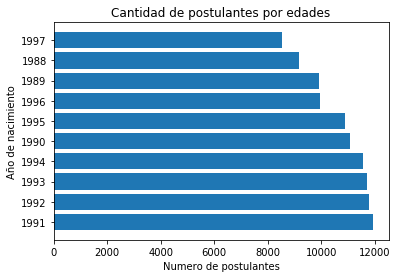

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

ages = [t[0] for t in edades_test]
y_pos = np.arange(len(ages))
num_people = [t[1] for t in edades_test]

plt.barh(y_pos, num_people)
plt.yticks(y_pos, ages)
plt.ylabel('Año de nacimiento')
plt.xlabel('Número de postulantes')
plt.title('Cantidad de postulantes por edades')

plt.show()

Text(0,0.5,'Edad')

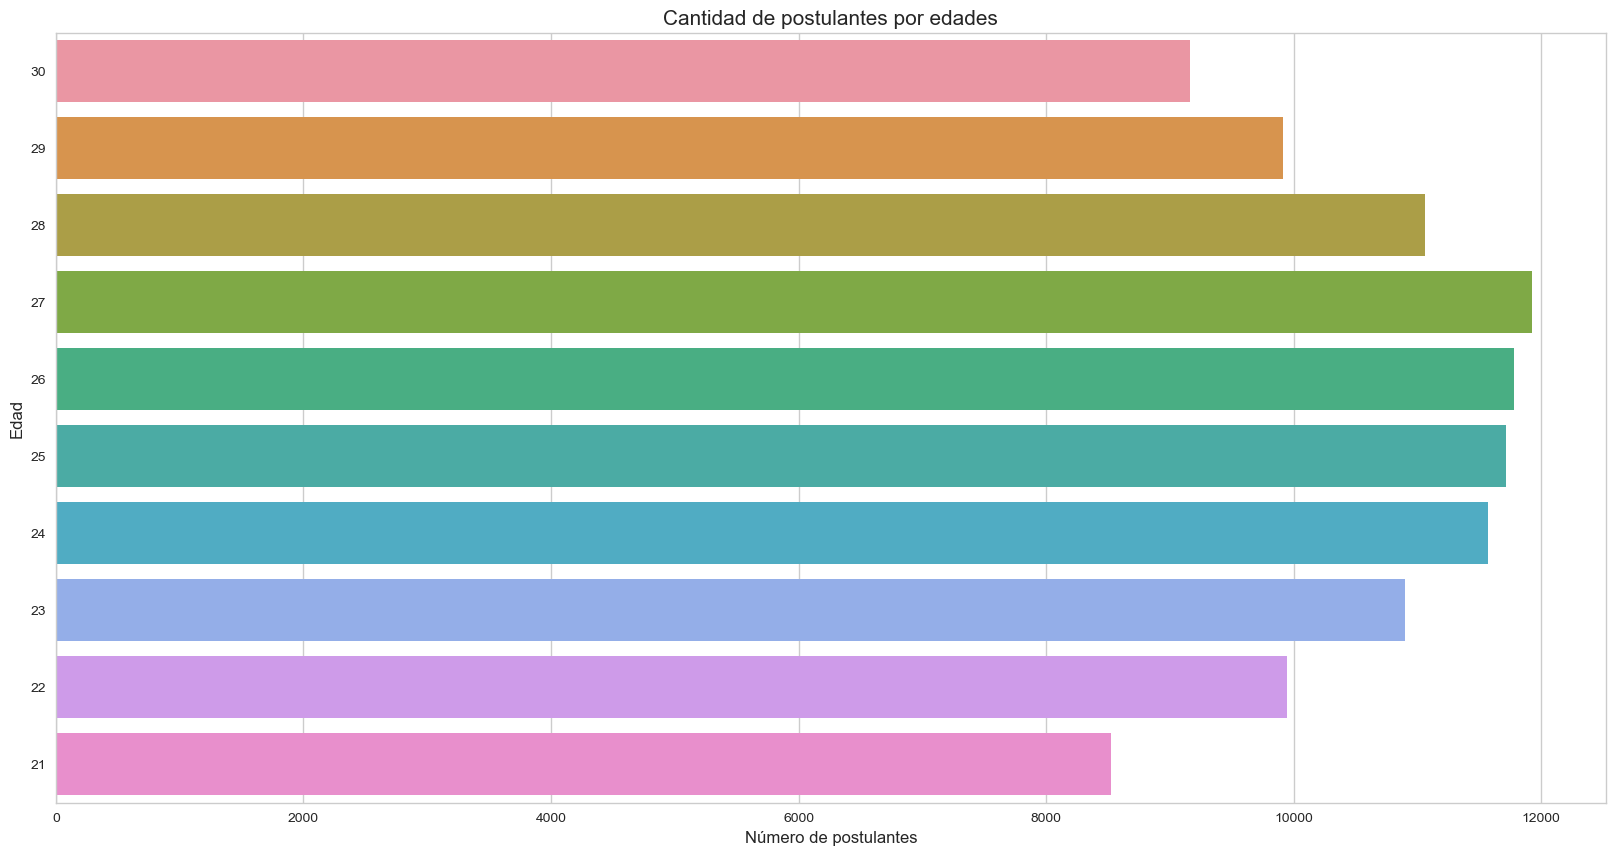

In [105]:

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

edad_test = sorted(edades_test)
num_people2 = [t[1] for t in edad_test]

ages2 = [2018 - int(t[0]) for t in edad_test]
g = sns.barplot(x=num_people2, y=ages2, orient='h', order=ages2)
g.set_title("Cantidad de postulantes por edades", fontsize=15)
g.set_xlabel("Número de postulantes", fontsize=12)
g.set_ylabel("Edad", fontsize=12)


In [103]:
edad_test

[('1988', 9161),
 ('1989', 9914),
 ('1990', 11064),
 ('1991', 11925),
 ('1992', 11780),
 ('1993', 11718),
 ('1994', 11570),
 ('1995', 10902),
 ('1996', 9944),
 ('1997', 8525)]

In [51]:
from operator import add
rdd = sc.parallelize([("a", 1), ("b", 1), ("a", 1)])
sorted(rdd.reduceByKey(add).collect())


[('a', 2), ('b', 1)]

## 3- Realizar una visualización que nos permita analizar la evolución de cantidad de visitas por día y el nivel de estudio alcanzado por el postulante. 
El tipo de visualización será propuesto por el alumno

**Nota**: Tener en cuenta que el nivel educativo del postulante dependerá de si el
mismo fue completado, abandonado etc, por lo que para definir un nivel de estudio
alcanzado hay que considerar tanto el nivel de estudios como el estado en el que se
encuentra para el postulante: (Por ejemplo “Universitario En Curso” o “Universitario
Abandonado” son casos válidos).